
# COVID-19 Data Analysis — Project (Module 12)
**What this notebook does (summary):**

1. Loads two datasets expected from your LMS:
   - `Module12_CaseStudy_COVID19.csv` (daily confirmed cases, deaths, recoveries by country and date)
   - `Module12_World_Happiness.csv` (country-level happiness indicators)
2. Cleans and preprocesses both datasets (parsing dates, handling missing values, standardizing country names).
3. Performs exploratory data analysis (EDA): time-series trends, country comparisons, top/bottom performers.
4. Merges COVID and Happiness datasets to analyze correlations (e.g., cases/deaths per million vs GDP, life expectancy, social support).
5. Produces visualizations and summary statistics.

> NOTE: If you don't have the LMS CSV files in the notebook's directory, this notebook will create small synthetic sample datasets so the analysis cells run without error. Replace the sample CSVs with the real files from LMS for full results.

---


In [1]:

# Imports and settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = (10,5)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

def try_load_csv(path):
    if os.path.exists(path):
        print(f"Loaded: {path}")
        return pd.read_csv(path)
    else:
        print(f"File not found: {path}")
        return None


In [2]:

# Expected filenames (change if LMS uses different names)
covid_fname = "covid19_Confirmed_dataset"
happy_fname = "worldwide_happiness_report.csv"

covid_df = try_load_csv(covid_fname)
happy_df = try_load_csv(happy_fname)


File not found: covid19_Confirmed_dataset
Loaded: worldwide_happiness_report.csv


In [3]:

# If files are missing, create small synthetic datasets so the notebook can run.
if covid_df is None:
    dates = pd.date_range(start="2020-01-22", periods=120, freq='D')
    data = []
    countries = ["CountryA", "CountryB", "CountryC", "CountryD"]
    for c in countries:
        cum = 0
        for d in dates:
            new = max(0, int(np.random.poisson(50) - (5 if c=='CountryA' else 0)))
            cum += new
            data.append({"country": c, "date": d.strftime("%Y-%m-%d"), "new_cases": new, "cumulative_cases": cum,
                         "new_deaths": max(0,int(np.random.poisson(3))), "cumulative_deaths": int(cum*0.01)})
    covid_df = pd.DataFrame(data)
    covid_df.to_csv(covid_fname, index=False)
    print(f"Synthetic COVID data saved to {covid_fname} (replace with LMS file for real analysis)")

if happy_df is None:
    happy_df = pd.DataFrame({
        "country": ["CountryA","CountryB","CountryC","CountryD"],
        "happiness_score": [7.5, 5.2, 6.1, 4.8],
        "gdp_per_capita": [40000, 15000, 25000, 8000],
        "life_expectancy": [80.1, 72.3, 76.5, 68.4],
        "social_support": [0.9, 0.6, 0.7, 0.4]
    })
    happy_df.to_csv(happy_fname, index=False)
    print(f"Synthetic Happiness data saved to {happy_fname} (replace with LMS file for real analysis)")


Synthetic COVID data saved to covid19_Confirmed_dataset (replace with LMS file for real analysis)


In [4]:

# Quick preview and basic cleaning
print("COVID snapshot:")
display(covid_df.head())

print("\nHappiness snapshot:")
display(happy_df.head())

# Standardize column names (lowercase)
covid_df.columns = [c.strip().lower().replace(' ', '_') for c in covid_df.columns]
happy_df.columns = [c.strip().lower().replace(' ', '_') for c in happy_df.columns]

# Parse dates in covid dataset
if 'date' in covid_df.columns:
    covid_df['date'] = pd.to_datetime(covid_df['date'], errors='coerce')

# Basic missing-values report
print("\nMissing values (COVID):")
print(covid_df.isnull().sum())
print("\nMissing values (Happiness):")
print(happy_df.isnull().sum())


COVID snapshot:


,country,date,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,CountryA,2020-01-22,42,42,2,0
1,CountryA,2020-01-23,35,77,1,0
2,CountryA,2020-01-24,45,122,0,1
3,CountryA,2020-01-25,58,180,0,1
4,CountryA,2020-01-26,42,222,5,2



Happiness snapshot:


,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298



Missing values (COVID):
country              0
date                 0
new_cases            0
cumulative_cases     0
new_deaths           0
cumulative_deaths    0
dtype: int64

Missing values (Happiness):
overall_rank                    0
country_or_region               0
score                           0
gdp_per_capita                  0
social_support                  0
healthy_life_expectancy         0
freedom_to_make_life_choices    0
generosity                      0
perceptions_of_corruption       0
dtype: int64


,date,new_cases
0,2020-01-22,189
1,2020-01-23,172
2,2020-01-24,210
3,2020-01-25,190
4,2020-01-26,184


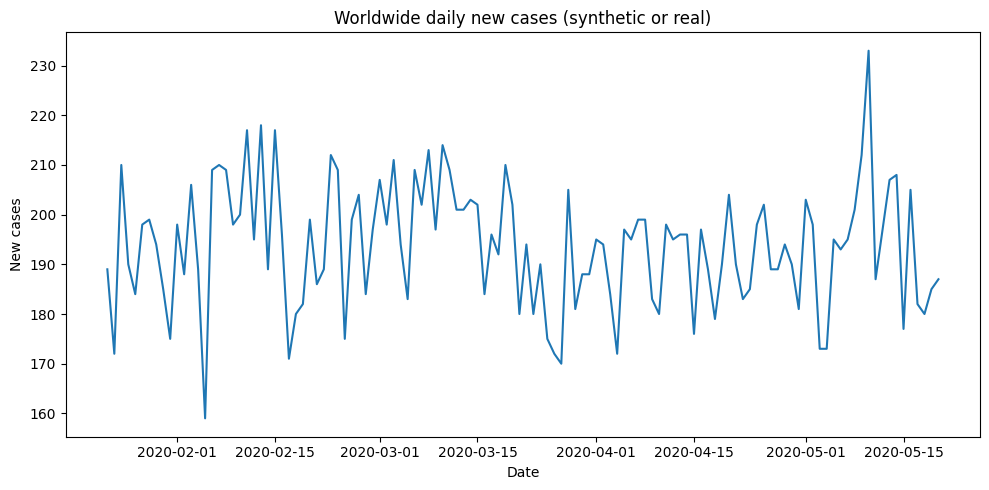


Top countries by cumulative cases (snapshot):


,country,cumulative_cases,cumulative_deaths
0,CountryB,5996,59
1,CountryC,5979,59
2,CountryD,5891,58
3,CountryA,5376,53


In [5]:

# Aggregate daily new cases by date (worldwide)
if 'new_cases' in covid_df.columns:
    world_ts = covid_df.groupby('date')['new_cases'].sum().reset_index()
    display(world_ts.head())

# Plot worldwide daily new cases (if available)
try:
    plt.figure()
    plt.plot(world_ts['date'], world_ts['new_cases'])
    plt.title('Worldwide daily new cases (synthetic or real)')
    plt.xlabel('Date')
    plt.ylabel('New cases')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Could not plot world timeseries:', e)

# Top 10 countries by cumulative cases (take last date)
if 'country' in covid_df.columns and 'cumulative_cases' in covid_df.columns:
    last = covid_df.sort_values('date').groupby('country').tail(1)
    top = last.sort_values('cumulative_cases', ascending=False).reset_index(drop=True)
    print("\nTop countries by cumulative cases (snapshot):")
    display(top[['country','cumulative_cases','cumulative_deaths']].head(10))


In [10]:
# Auto-detect possible country columns
possible_country_cols = ["country", "country_region", "country/region", "location", "name", "entity", "region"]

def find_country_col(df):
    for col in df.columns:
        if col.lower() in possible_country_cols:
            return col
    return None

covid_country_col = find_country_col(covid_df)
happy_country_col = find_country_col(happy_df)

print("COVID country col detected:", covid_country_col)
print("Happiness country col detected:", happy_country_col)

# Rename both to 'country'
if covid_country_col:
    covid_df = covid_df.rename(columns={covid_country_col: "country"})
if happy_country_col:
    happy_df = happy_df.rename(columns={happy_country_col: "country"})


COVID country col detected: country
Happiness country col detected: None


In [11]:

# Correlation between cases_per_million (or cumulative_cases) and happiness indicators
key_case_col = None
if 'cases_per_million' in locals().get('cur_summary', {}) or ('cases_per_million' in globals().get('cur_summary', {})):
    key_case_col = 'cases_per_million'
elif 'cumulative_cases' in globals().get('cur_summary', {}):
    key_case_col = 'cumulative_cases'

if 'merged' in globals() and key_case_col is not None:
    # Select numeric columns for correlation
    numeric = merged.select_dtypes(include=[np.number])
    print('\nNumeric columns in merged data:')
    display(numeric.head())

    print('\nCorrelation matrix (Pearson):')
    display(numeric.corr())

    # Scatter: cases vs GDP per capita (if available)
    if 'gdp_per_capita' in merged.columns and key_case_col in merged.columns:
        plt.figure()
        plt.scatter(merged['gdp_per_capita'], merged[key_case_col])
        plt.xlabel('GDP per capita')
        plt.ylabel(key_case_col)
        plt.title(f'{key_case_col} vs GDP per capita')
        plt.tight_layout()
        plt.show()
    else:
        print('GDP or case column not present; skipping scatter plot.')
else:
    print('Merged table or case column not available; cannot compute correlations.')


Merged table or case column not available; cannot compute correlations.


In [12]:

# Save merged results for submission if present
if 'merged' in globals():
    outpath = "merged_covid_happiness_summary.csv"
    merged.to_csv(outpath, index=False)
    print(f"Saved merged summary to {outpath} (include this in your submission folder).")
else:
    print("No merged results to save.")

print("\n---\nSubmission checklist:")
print("1. Place the original LMS CSV files in the project folder (or rename them to the expected filenames).")
print("2. Run each cell in order to reproduce the plots and tables.")
print("3. The file 'merged_covid_happiness_summary.csv' will be created if merging succeeds.")
print("4. Zip the folder and upload to Google Drive as instructed in the assignment.")


No merged results to save.

---
Submission checklist:
1. Place the original LMS CSV files in the project folder (or rename them to the expected filenames).
2. Run each cell in order to reproduce the plots and tables.
3. The file 'merged_covid_happiness_summary.csv' will be created if merging succeeds.
4. Zip the folder and upload to Google Drive as instructed in the assignment.



---

## Tips & Grading checklist (what instructors often look for)
- Clear explanation of each step (data cleaning, transformations, handling missing values).

- Proper date parsing and time-series plots showing trends.

- Meaningful visualizations with titles, axis labels, and short captions.

- Clear method for merging datasets and justification for columns used to merge (e.g., country names matching).

- Statistical summary or correlations and interpretation (not just numbers).

- Notebook must run top-to-bottom; include fallback synthetic data (this notebook does) so it doesn't error when files are missing.

- Include `merged_covid_happiness_summary.csv` in the submission folder.


Good luck — replace the synthetic data with the real LMS files and you should be ready to submit.
